# News Categorizer

Predicting news article categories by headline text.

Compares three models: Naive Bayes, SGD, and neural network, then
applies the trained neural network to roughly categorize 2020 New York Times headlines.

> The dataset is from https://www.kaggle.com/uciml/news-aggregator-dataset.
>
> It contains headlines, URLs, and categories for 422,937 news stories
collected by a web aggregator between March 10th, 2014 and August 10th, 2014.
>
> Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import time
import string
import os
import csv
import re

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

Using TensorFlow backend.


## Retrieve raw data

Read dataset as a CSV from local file.

In [2]:
print('Retrieving raw data...')
news_df = pd.read_csv(os.path.join('news-data', 'uci-news-aggregator.csv'), header=0, index_col=0, dtype=str)
print('Read CSV file from local copy of dataset.')
print(news_df.shape)
news_df.head()

Retrieving raw data...
Read CSV file from local copy of dataset.
(422419, 7)


,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


## Pre-preprocessing

Preprocessing transformations that can happen before the train/test split are those that are not dependent on the values contained in the dataset itself.

Such steps are:

* Checking for null values
* Renaming columns
* Standardising case
* Removing punctuation

There are 2 null values in `PUBLISHER`,
but that field is neither a relevant feature nor the label to be predicted.

In [3]:
# Check for null values
news_df.isnull().sum()

TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [4]:
# Make labels more intuitive and human-readable
CATEGORY_DICT = {
    'b':'business',
    'e':'entertainment',
    'm':'health',
    't':'science/technology'
}

news_df['CATEGORY'] = news_df['CATEGORY'].map(CATEGORY_DICT)

In [5]:
def remove_punctuation(s1):
    """
    Returns s1 unicode-normalised without punctuation.
    """
    s1 = s1.translate(str.maketrans('', '', string.punctuation))

    return unicodedata.normalize("NFKD", s1)

The relevant feature is the headline text (in `TITLE`), and the label is the news category (in `CATEGORY`).

In [6]:
print('Standardising case and removing punctuation...')

# Make all the headlines lowercase and remove punctuation
news_df['TITLE'] = news_df['TITLE'].str.lower()
news_df['TITLE'] = news_df['TITLE'].apply(remove_punctuation)

# Designate features and labels
features = news_df[['TITLE']]
labels = news_df[['CATEGORY']]

news_df.head()

Standardising case and removing punctuation...


,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,fed official says weak data caused by weather ...,http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,feds charles plosser sees high bar for change ...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,us open stocks fall after fed official hints a...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,fed risks falling behind the curve charles plo...,http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,feds plosser nasty weather has curbed job growth,http://www.moneynews.com/Economy/federal-reser...,Moneynews,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


There are 4 news categories
Saving as output/training_data_composition.png...


<Figure size 432x288 with 0 Axes>

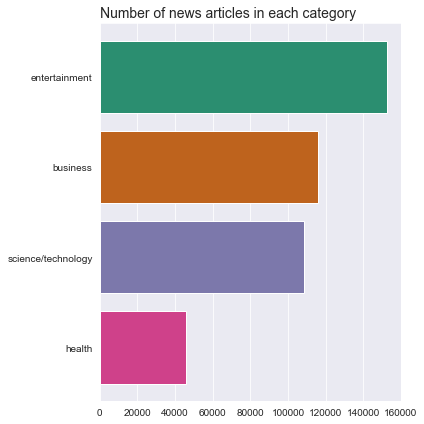

In [7]:
count_df = pd.DataFrame(news_df['CATEGORY'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

plt.clf()
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
sns.barplot(data=count_df, y='index', x='CATEGORY', palette='Dark2')
plt.title('Number of news articles in each category', loc='left', fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig(os.path.join('output', 'training_data_composition.png'))
print('Saving as output/training_data_composition.png...')
plt.plot();

# Statistical machine learning approach, naive Bayes and SGD

We use `sklearn`'s implementations of both models.

In [8]:
print('===== Naive Bayes and SGD =====')

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

===== Naive Bayes and SGD =====


((337935, 1), (84484, 1), (337935, 1), (84484, 1))

## Preprocessing

In each instance, we avoid data leakage by
"fitting on train and transforming both train and test".

This ensures that information contained in the test set
is not factored in by the model at training time (avoids over-optimistic results).


The preprocessing steps are shared between naive Bayes and SGD:

* Convert text (the single feature) into count vectors (**removing stop words in the process**)
* Encode the categories (the label)

In [9]:
start_time = time.time()

print('Vectorising text into features and encoding categorical labels...')

# Turn text into integer count vectors
vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(x_train['TITLE'])

x_train = vectorizer.transform(x_train['TITLE'])
x_test = vectorizer.transform(x_test['TITLE'])

# Turn categories into integers
# 0: business, 1: entertainment, 2: health, 3: science/technology
encoder = LabelEncoder()
encoder.fit(y_train['CATEGORY'])

y_train = encoder.transform(y_train['CATEGORY'])
y_test = encoder.transform(y_test['CATEGORY'])

duration = time.time() - start_time
print(f'Preprocessing for Naive Bayes and SGD took {duration} seconds.')

Vectorising text into features and encoding categorical labels...
Preprocessing for Naive Bayes and SGD took 7.7970709800720215 seconds.


## Training and evaluating the models

Both models' accuracies are high, above 90%, with default parameters.

SGD outperforms the Naive Bayes **(\~93.7% compared to \~92.6% in the sample run)**, but takes slightly longer to train.

In [10]:
print('Training and evaluating Naive Bayes...')
start_time = time.time()

# Naive Bayes model
nb = MultinomialNB()
nb.fit(x_train, y_train)

duration = time.time() - start_time
print(f'Training the Naive Bayes model took {duration} seconds.')

score = nb.score(x_test, y_test)
print(f'Multinomial Naive Bayes accuracy:\n{score}')

Training and evaluating Naive Bayes...
Training the Naive Bayes model took 0.08646726608276367 seconds.
Multinomial Naive Bayes accuracy:
0.9303536764357748


In [11]:
print('Training and evaluating SGD...')
start_time = time.time()

# Stochastic gradient descent classifier
sgd = SGDClassifier(early_stopping=True)
sgd.fit(x_train, y_train)

duration = time.time() - start_time
print(f'Training the SGD model took {duration} seconds.')

score = sgd.score(x_test, y_test)
print(f'SGD classsifier accuracy:\n{score}')

Training and evaluating SGD...
Training the SGD model took 2.6988070011138916 seconds.
SGD classsifier accuracy:
0.937289901046352


### Some other classifier models

These models are relatively slow to train, and underperformed in tests.

In [12]:
# from sklearn.svm import LinearSVC

# svc = LinearSVC()
# svc.fit(x_train, y_train)
# svc.score(x_test, y_test)

In [13]:
# from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier()
# forest = forest.fit(x_train, y_train)
# forest.score(x_test, y_test)

## Visualizing the predictions

We use `seaborn`'s heatmap to visualise the confusion matrices.

In [14]:
def visualise_confusion_matrix(model_name, confusion_matrix, cmap='YlOrBr'):
    '''
    Displays the given confusion matrix for the given model name.
    '''

    cm = pd.DataFrame(confusion_matrix)
    plt.clf()
    sns.set(font_scale = 1)
    plt.figure(figsize = (8,8))
    
    # x and y labels are based on the global CATEGORY_DICT
    sns.heatmap(cm, cmap = cmap,linewidths = 1, annot = True,square = True, fmt='d', cbar = False,
                xticklabels = CATEGORY_DICT.values(),
                yticklabels = CATEGORY_DICT.values())
    plt.xticks(rotation = 0)
    plt.yticks(rotation = 0)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Classes', rotation=0)
    plt.ylabel('Actual Classes', rotation=0)
    plt.tight_layout()
    plt.plot()
    plt.savefig(os.path.join('output', f'confusion_matrix_{model_name}.png'))
    print(f'Saving as output/confusion_matrix_{model_name}.png...')
    

### Visualize Naive Bayes

Saving as output/confusion_matrix_Naive Bayes.png...


<Figure size 432x288 with 0 Axes>

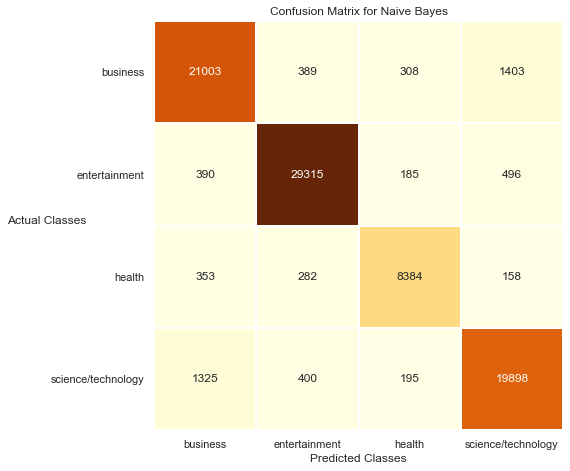

In [15]:
# Visualise Naive Bayes
y_pred = nb.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
visualise_confusion_matrix('Naive Bayes', matrix)

### Visualize SGD

Saving as output/confusion_matrix_SGD.png...


<Figure size 432x288 with 0 Axes>

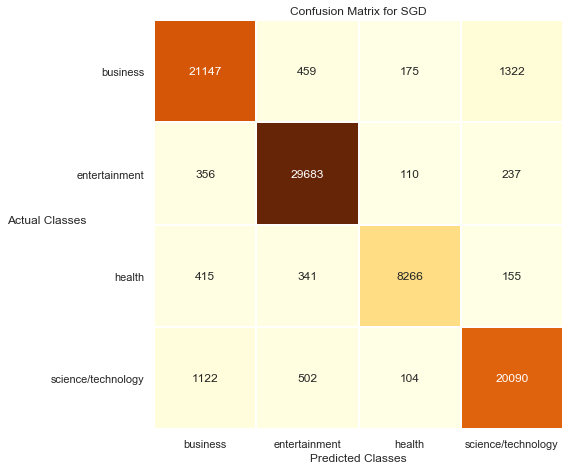

In [16]:
y_pred = sgd.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
visualise_confusion_matrix('SGD', matrix)

## Testing the models on data not in the dataset

In [17]:
def predict_categories(model, titles):
    '''
    Use the given model to predict categories for the given news headline titles. 
    '''
    titles = pd.Series(titles)
    
    # mirror preprocessing transformations before feeding as input to the model
    titles = titles.str.lower()
    titles = titles.apply(remove_punctuation)
    
    text = vectorizer.transform(titles)

    categories = model.predict(text)
    
    return encoder.inverse_transform(categories)

Now we test the models on some recent (June 2020) article headlines from the New York Times, Reuters, E!, and other websites. Some non-obvious headlines (e.g. 'Watch This Black Hole Blow Bubbles') are deliberately chosen.

In [18]:
titles = [
    'The Sea’s Weirdest Creatures, Now in ‘Staggering’ Detail',
    'Watch This Black Hole Blow Bubbles',
    'Falling Jobless Rate Could Imperil Aid Underpinning the Recovery',
    'OPEC and Russia Are Likely to Extend Oil Production Cuts',
    'Doctors Heavily Overprescribed Antibiotics Early in the Pandemic',
    '15 Years Since Tom Cruise Infamously Jumped on Oprah\'s Couch',
    'YouTube is hosting a star-studded tribute to the class of 2020 this weekend',
    'Malaysia reports 37 new coronavirus cases, one new death',
    'Protests in Australia, Japan embrace \'Black Lives Matter\' movement',
    'Tesla Model Y attacks the race track on Autopilot'
]
test_df = pd.DataFrame(titles, columns=['title'])

In [19]:
# Naive Bayes predictions

test_df['predicted_category'] = predict_categories(nb, titles)
test_df.sort_values(by='predicted_category')

,title,predicted_category
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
8,"Protests in Australia, Japan embrace 'Black Li...",business
1,Watch This Black Hole Blow Bubbles,entertainment
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
6,YouTube is hosting a star-studded tribute to t...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
7,"Malaysia reports 37 new coronavirus cases, one...",health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
9,Tesla Model Y attacks the race track on Autopilot,science/technology


In [20]:
# SGD predictions

test_df['predicted_category'] = predict_categories(sgd, titles)
test_df.sort_values(by='predicted_category')

,title,predicted_category
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
8,"Protests in Australia, Japan embrace 'Black Li...",business
1,Watch This Black Hole Blow Bubbles,entertainment
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
6,YouTube is hosting a star-studded tribute to t...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
7,"Malaysia reports 37 new coronavirus cases, one...",health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
9,Tesla Model Y attacks the race track on Autopilot,science/technology


We see that the predictions of the two models are similar and mostly accurate,
and that **it is able to classify 2020 topics, despite being trained on 2014 news headlines.**

## Custom tests

To test a model on arbitrary input:

In [21]:
print('Predicting categories for arbitrary input:')

custom_title = 'Bloomberg, Justin Bieber, Heart Surgery, and the Milky Way'
#custom_title = input("(Naive Bayes) Type in any news headline:\n\n")
print(custom_title)
if (custom_title):
    print(
        f'predicted category: '
        f'{predict_categories(nb, [custom_title,])[0]}.'
    )

Predicting categories for arbitrary input:
Bloomberg, Justin Bieber, Heart Surgery, and the Milky Way
predicted category: entertainment.


# Neural Network Approach with Keras

We use `TensorFlow` with `Keras`'s API.

Split data again and start fresh: neural networks have different input constraints.

In [22]:
print('===== Neural Network =====')
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

===== Neural Network =====


((337935, 1), (84484, 1), (337935, 1), (84484, 1))

## Preprocessing

As before, each step here is taken so as to prevent data leakage from the testing set before or during training.

We consider the average length of headline text in the dataset, to decide on the maximum length of input to the neural network. **200** seems sensible.

In [23]:
headline_lengths = [len(x) for x in news_df['TITLE'].values]
print(f'average length of headline text: {np.mean(headline_lengths):.3f} characters')

average length of headline text: 54.909 characters


Turns titles into sequences of integers with `Tokenizer`. This takes about a minute.

In [24]:
start_time = time.time()

print('Tokenising text into sequences...')

# Turn titles into lists of tokens:
# each token is represented by a number,
# which is its index in the dictionary of 10000 most common unique tokens
# contained in the text it was fitted on, i.e. all the headlines in the dataset.

n_most_common_words = 10000

tokenizer = Tokenizer(num_words=n_most_common_words, filters=string.punctuation, lower=True)
tokenizer.fit_on_texts(x_train['TITLE'].values)

x_train = tokenizer.texts_to_sequences(x_train['TITLE'].values)
x_test = tokenizer.texts_to_sequences(x_test['TITLE'].values)

Tokenising text into sequences...


Pad or truncate the input sequences so they are compatible with the input layer of the neural network, and
one hot encode the output categorical labels, so they are compatible with the output layer of the neural network.

In [25]:
print('Padding sequences...')

# set max title length to be used as input to be 200
# pad and truncate as necessary
max_title_length = 200

x_train = pad_sequences(x_train, maxlen=max_title_length)
x_test = pad_sequences(x_test, maxlen=max_title_length)

x_train.shape

Padding sequences...


(337935, 200)

In [26]:
print('One-hot encoding categorical labels...')

onehot = OneHotEncoder()
onehot.fit(y_train)

y_train = onehot.transform(y_train)
y_test = onehot.transform(y_test)

duration = time.time() - start_time
print(f'Training the neural network took {duration} seconds.')

One-hot encoding categorical labels...
Training the neural network took 13.284749984741211 seconds.


## Compiling the neural network

Two hidden dense layers are used. The sigmoid activation function for the last layer is appropriate (**as opposed to the softmax function**) in this case since the four output categories are not exhaustive and mutually exclusive.

In [27]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(n_most_common_words, embedding_vector_length, input_length=max_title_length))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                102416    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 422,756
Trainable params: 422,756
Non-trainable params: 0
_________________________________________________________________
None


## Training and evaluating the neural network

Training the model for 4 epochs takes several minutes.

The neural network performs well, with **high accuracy (\~96.80%) and low loss (\~8.75% in the sample run).**
Notably, it performs better than both the Naive Bayes and SGD models.

In [28]:
start_time = time.time()

# Train the model for 4 epochs.
hist = model.fit(x_train, y_train.todense(),
                 validation_data=(x_test, y_test.todense()),
                 epochs=4,
                 batch_size=128)

duration = time.time() - start_time
print(f'Training the neural network took {duration} seconds.')

C:\Users\Jonathan\miniconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 337935 samples, validate on 84484 samples
Epoch 1/4
337935/337935 [==============================] - 23s 68us/step - loss: 0.1666 - accuracy: 0.9335 - val_loss: 0.1032 - val_accuracy: 0.9622
Epoch 2/4
337935/337935 [==============================] - 24s 72us/step - loss: 0.0876 - accuracy: 0.9678 - val_loss: 0.0938 - val_accuracy: 0.9650
Epoch 3/4
337935/337935 [==============================] - 23s 69us/step - loss: 0.0754 - accuracy: 0.9722 - val_loss: 0.0876 - val_accuracy: 0.9673
Epoch 4/4
337935/337935 [==============================] - 24s 71us/step - loss: 0.0648 - accuracy: 0.9763 - val_loss: 0.0888 - val_accuracy: 0.9671
Training the neural network took 95.39286875724792 seconds.


In [29]:
score = model.evaluate(x_test,y_test)
print(f'Test set\n  Loss: {score[0]}\n  Accuracy: {score[1]}')

84484/84484 [==============================] - 2s 27us/step
Test set
  Loss: 0.08884787340553008
  Accuracy: 0.9671476483345032


## Visualizing the training process

Training and validation accuracy and loss across epochs are plotted. Overfitting does not seem to be issue.

Saving as output/nn_accuracy.png...


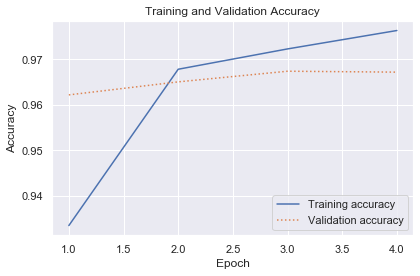

In [30]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.clf()
sns.set()
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join('output', 'nn_accuracy.png'))
print(f'Saving as output/nn_accuracy.png...')

plt.plot();

Saving as output/nn_loss.png...


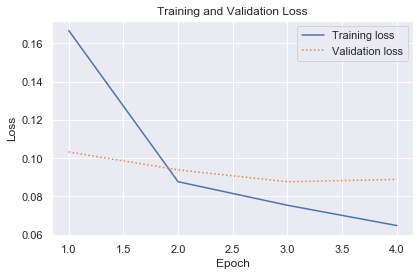

In [31]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.clf()
plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join('output', 'nn_loss.png'))
print(f'Saving as output/nn_loss.png...')

plt.plot();

## Testing the neural network on data not in the dataset

We predict on the same 2020 titles as before, and observe that the predictions are similarly accurate.

In [32]:
titles

['The Sea’s Weirdest Creatures, Now in ‘Staggering’ Detail',
 'Watch This Black Hole Blow Bubbles',
 'Falling Jobless Rate Could Imperil Aid Underpinning the Recovery',
 'OPEC and Russia Are Likely to Extend Oil Production Cuts',
 'Doctors Heavily Overprescribed Antibiotics Early in the Pandemic',
 "15 Years Since Tom Cruise Infamously Jumped on Oprah's Couch",
 'YouTube is hosting a star-studded tribute to the class of 2020 this weekend',
 'Malaysia reports 37 new coronavirus cases, one new death',
 "Protests in Australia, Japan embrace 'Black Lives Matter' movement",
 'Tesla Model Y attacks the race track on Autopilot']

In [33]:
def predict_categories_nn(model, titles):
    '''
    Use the given neural network model to predict categories for the given news headline titles. 
    '''
    sequences = tokenizer.texts_to_sequences(titles)
    text = pad_sequences(sequences, maxlen=max_title_length)

    categories = model.predict_classes(text)
    
    return encoder.inverse_transform(categories)

In [34]:
test_df['predicted_category'] = predict_categories_nn(model, titles)

test_df.sort_values(by='predicted_category')

,title,predicted_category
1,Watch This Black Hole Blow Bubbles,business
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
8,"Protests in Australia, Japan embrace 'Black Li...",business
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
6,YouTube is hosting a star-studded tribute to t...,health
7,"Malaysia reports 37 new coronavirus cases, one...",health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
9,Tesla Model Y attacks the race track on Autopilot,science/technology


## Custom tests

To test the neural network on arbitrary input:

In [35]:
print('Predicting categories for arbitrary input:')

custom_title = 'Bloomberg, Justin Bieber, Heart Surgery, and the Milky Way'
#custom_title = input("(Neural Network) Type in a news headline:\n\n")
print(custom_title)
if custom_title:
    print(
        f'predicted category: '
        f'{predict_categories_nn(model, [custom_title,])[0]}.'
    )

Predicting categories for arbitrary input:
Bloomberg, Justin Bieber, Heart Surgery, and the Milky Way
predicted category: entertainment.


## Summary

The neural network was the most accurate by far, but it was also the slowest to train.
It appears that for medium-sized text datasets such as this, the Naive Bayes  or SGD
models are just as practically useful.

## Applying the model: 'How has 2020 been so far?'

In terms of the 4 news categories as defined in 2014, what has the news been reporting recently?

To get a rough answer, we use the trained neural network to predict categories for 2020 headlines from the New York Times.

> The 2020 headlines were obtained from the free monthly articles on [the New York Times site map](https://spiderbites.nytimes.com/2020/). \
> © 2020 The New York Times Company

In [36]:
print('===== 2020 New York Times category predictions =====')

# Read local copies of monthly headlines
jan2020_df = pd.read_csv(os.path.join('news-data', 'nyt_jan2020.csv'), header=0, index_col=0, dtype=str)
print('Read 2020 headlines CSV file from local copy.')

jan2020_df = jan2020_df.drop_duplicates()
jan2020_df['month'] = 'january'

print(jan2020_df.shape)
jan2020_df.head()

===== 2020 New York Times category predictions =====
Read 2020 headlines CSV file from local copy.
(3575, 2)


,headline,month
0,#MeToo Cases’ New Legal Battleground: Defamati...,january
1,"$1 Million Homes in South Dakota, Illinois and...",january
2,"$1 Million Homes in South Dakota, Illinois and...",january
3,"$1.2 Million Homes in New York, California and...",january
4,$1.4 Million Homes in California,january


Combine the rest of the months into a single DataFrame.

In [37]:
feb2020_df = pd.read_csv(os.path.join('news-data', 'nyt_feb2020.csv'), header=0, index_col=0, dtype=str)
feb2020_df = feb2020_df.drop_duplicates()
feb2020_df['month'] = 'february'

mar2020_df = pd.read_csv(os.path.join('news-data', 'nyt_mar2020.csv'), header=0, index_col=0, dtype=str)
mar2020_df = mar2020_df.drop_duplicates()
mar2020_df['month'] = 'march'

apr2020_df = pd.read_csv(os.path.join('news-data', 'nyt_apr2020.csv'), header=0, index_col=0, dtype=str)
apr2020_df = apr2020_df.drop_duplicates()
apr2020_df['month'] = 'april'

may2020_df = pd.read_csv(os.path.join('news-data', 'nyt_may2020.csv'), header=0, index_col=0, dtype=str)
may2020_df = may2020_df.drop_duplicates()
may2020_df['month'] = 'may'

nyt2020_df = jan2020_df.append(feb2020_df).append(mar2020_df).append(apr2020_df).append(may2020_df).astype(str)

Predict categories for each of the 17k+ headlines with the trained neural network. We can see that some of them are inaccurate, as the categories it was trained on did not include, for instance, politics or market prices.

In [38]:
nyt2020_df['predicted_category'] = predict_categories_nn(model, nyt2020_df['headline'])
nyt2020_df.to_csv(os.path.join('output', 'nyt2020_predictions.csv'))
print('Saving 2020 New York Times news category predictions to output/nyt2020_predictions.csv')
nyt2020_df.head()

Saving 2020 New York Times news category predictions to output/nyt2020_predictions.csv


,headline,month,predicted_category
0,#MeToo Cases’ New Legal Battleground: Defamati...,january,business
1,"$1 Million Homes in South Dakota, Illinois and...",january,business
2,"$1 Million Homes in South Dakota, Illinois and...",january,business
3,"$1.2 Million Homes in New York, California and...",january,business
4,$1.4 Million Homes in California,january,business


In [39]:
# List of 4-tuples, each tuple representing the monthly category counts
category_counts = []

months = ['january', 'february', 'march', 'april', 'may']

for month in months:
    # Get counts per category for each month 
    monthly_category_counts = nyt2020_df[nyt2020_df['month'] == month]['predicted_category'].value_counts().sort_index()
    category_counts.append(list(monthly_category_counts))

# Turn into lists of category counts for each category
monthly_b, monthly_e, monthly_m, monthly_t = zip(*category_counts)

Saving as output/nyt2020.png...


<Figure size 432x288 with 0 Axes>

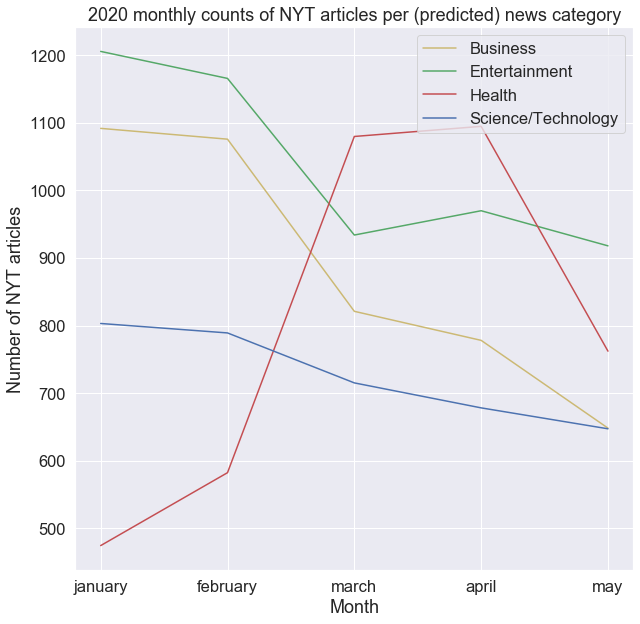

In [40]:
plt.clf()
sns.set(font_scale = 1.5)
plt.figure(figsize=(10,10))
plt.title('2020 monthly counts of NYT articles per (predicted) news category')

plt.plot(months, monthly_b, 'y-', label='Business')
plt.plot(months, monthly_e, 'g-', label='Entertainment')
plt.plot(months, monthly_m, 'r-', label='Health')
plt.plot(months, monthly_t, 'b-', label='Science/Technology')
plt.xlabel('Month')
plt.ylabel('Number of NYT articles')
plt.legend(loc='upper right')
plt.savefig(os.path.join('output', 'nyt2020.png'))
print(f'Saving as output/nyt2020.png...')
plt.plot();

## Remarks

Unsurprisingly, we see a very sharp increase in health-related articles recently. Perhaps as a consequence of that, there were slight declines in the counts for the other categories.

Though, because the 4 categories obviously do not encompass all of the New York Times' content, these results are not to be taken too seriously. In additions to this, there is also a considerable degree of randomness involved, so variations between runs are to be expected.

Possible extensions to this project include incorporating other news article datasets,
allow for more labels (categories), and multiple labels for one item (topics often overlap).
Also, with a few adjustments, these models can be trained on other medium-sized text data,
for instance, film synopses or YouTube comments.